# image layer tutorial

Welcome to the tutorial on the **napari** `Image` layer!

This tutorial assumes you have already installed **napari**, know how to launch
the viewer, and are familiar with its layout. For help with installation see our
[installation](./installation) tutorial. For help getting started with the
viewer see our [getting started](./getting_started) tutorial. For help
understanding the organisation of the viewer, including things like the layers
list, the layer properties widgets, the layer control panels, and the dimension
sliders see our [napari viewer](./viewer) tutorial.

This tutorial will teach you about the **napari** `Image` layer, including the
types of images that can be displayed, and how to set properties like the
contrast, opacity, colormaps and blending mode. At the end of the tutorial you
should understand how to add and manipulate a variety of different types of
images both from the GUI and from the console.

## a simple example

You can create a new viewer and add an image in one go using the
`napari.view_image` method, or if you already have an existing viewer, you can
add an image to it using `viewer.add_image`. The api of both methods is the
same. In these examples we'll mainly use `view_image`.

A simple example of viewing an image is as follows:

In [1]:
import napari
from skimage import data

cells = data.cells3d()[30, 1]  # grab some data
viewer = napari.view_image(cells, colormap='magma')

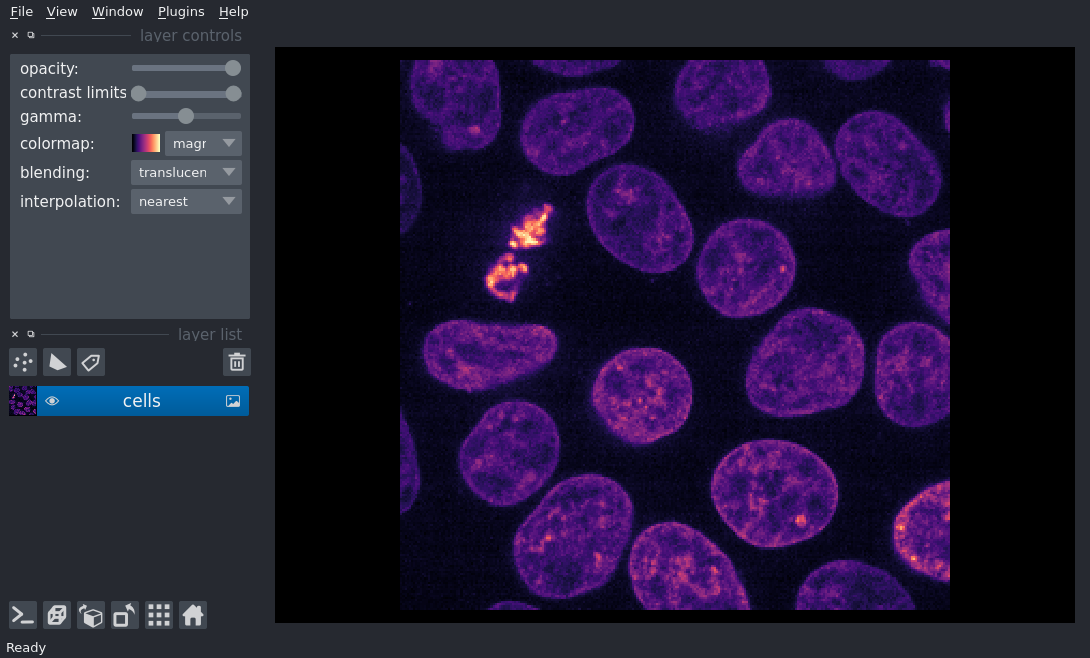

In [2]:
from napari.utils import nbscreenshot

nbscreenshot(viewer)

In [3]:
viewer.close()

## arguments of view_image and add_image

{meth}`~napari.view_layers.view_image` and {meth}`~napari.Viewer.add_image`
accept the same layer-creation parameters.

In [4]:
help(napari.view_image)

Help on function view_image:

view_image(data=None, *, channel_axis=None, rgb=None, colormap=None, contrast_limits=None, gamma=1, interpolation='nearest', rendering='mip', iso_threshold=0.5, attenuation=0.05, name=None, metadata=None, scale=None, translate=None, rotate=None, shear=None, affine=None, opacity=1, blending=None, visible=True, multiscale=None, title='napari', ndisplay=2, order=(), axis_labels=(), show=True) -> 'Union[Image, List[Image]]'
    Create a viewer and add an image layer.
    
    Parameters
    ----------
    data : array or list of array
        Image data. Can be N dimensional. If the last dimension has length
        3 or 4 can be interpreted as RGB or RGBA if rgb is `True`. If a
        list and arrays are decreasing in shape then the data is treated as
        a multiscale image.
    channel_axis : int, optional
        Axis to expand image along.  If provided, each channel in the data
        will be added as an individual image layer.  In channel_axis mode,

## image data and numpy-like arrays

napari can take any numpy-like array as input for its image layer. A numpy-like
array can just be a [numpy
array](https://docs.scipy.org/doc/numpy/reference/generated/numpy.array.html), a
[dask array](https://docs.dask.org/en/stable/array.html), an
[xarray](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.html), a
[zarr array](https://zarr.readthedocs.io/en/stable/api/core.html), or any other
object that you can index into and when you call
[`np.asarray`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.asarray.html)
on it you get back a numpy array.

The great thing about napari support array-like objects is that you get to keep
on using your favorite array libraries without worrying about any conversions as
we'll handle all of that for you.

napari will also wait until just before it displays data onto the screen to
actually generate a numpy array from your data, and so if you're using a library
like `dask` or `zarr` that supports lazy loading and lazy evaluation, we won't
force you load or compute on data that you're not looking at. This enables
napari to seamlessly browse enormous datasets that are loaded in the right way.
For example, here we are browsing over 100GB of lattice lightsheet data stored
in a zarr file:

![image: lattice light sheet microscopy](../assets/tutorials/LLSM.gif)

## image pyramids

For exceptionally large datasets napari supports image pyramids. An image
pyramid is a list of arrays, where each array is downsampling of the previous
array in the list, so that you end up with images of successively smaller and
smaller shapes. A standard image pyramid might have a 2x downsampling at each
level, but napari can support any type of pyramid as long as the shapes are
getting smaller each time.

Image pyramids are especially useful for incredibly large 2D images when viewed
in 2D or incredibly large 3D images when viewed in 3D. For example this ~100k x
200k pixel pathology image consists of 10 pyramid levels and can be easily
browsed as at each moment in time we only load the level of the pyramid and the
part of the image that needs to be displayed:

![image: pathology](../assets/tutorials/pathology.gif)

This example had precomputed image pyramids stored in a zarr file, which is best
for performance. If, however you don't have a precomputed pyramid but try and
show a exceptionally large image napari will try and compute pyramids for you
unless you tell it not too.

You can use the `is_pyramid` keyword argument to specify if your data is an
image pyramid or not. If you don't provide this value, then will try and guess
whether your data is or needs to be an image pyramid.

## 3D rendering of images

All our layers can be rendered in both 2D and 3D mode, and one of our viewer
buttons can toggle between each mode. The number of dimensions sliders will be 2
or 3 less than the total number of dimensions of the layer, allowing you to
browse volumetric timeseries data and other high dimensional data. See for
example these cells undergoing mitosis in this volumetric timeseries:

![image: mitorsis](../assets/tutorials/mitosis.gif)

## viewing rgb vs luminance (grayscale) images

In this example we explicitly set the `rgb` keyword to be `True`
because we know we are working with an `rgb` image:

In [5]:
viewer = napari.view_image(data.astronaut(), rgb=True)

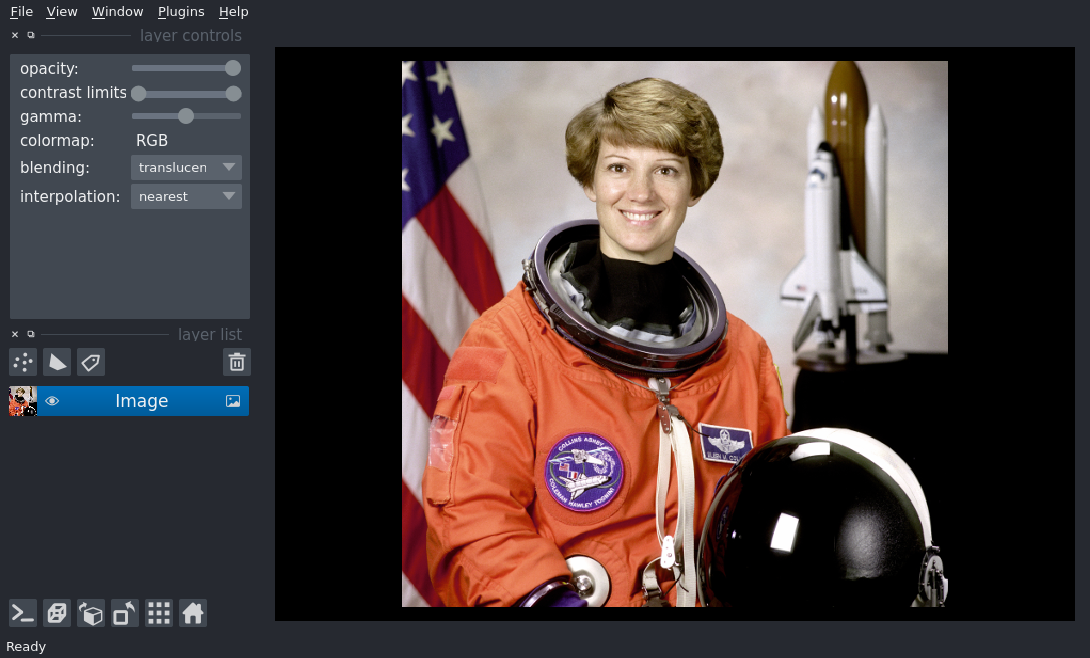

In [6]:
from napari.utils import nbscreenshot

nbscreenshot(viewer)

In [7]:
viewer.close()

If we had left that keyword argument out napari would have successfully guessed
that we were trying to show an `rgb` or `rgba` image because the final dimension
was 3 or 4. If you have a luminance image where the last dimension is 3 or 4 you
can set the `rgb` property to `False` so napari handles the image correctly.

`rgb` data must either be `uint8`, corresponding to values between 0 and 255, or
`float` and between 0 and 1. If the values are `float` and outside the 0 to 1
range they will be clipped.

## working with colormaps

napari supports any colormap that is created with `vispy.color.Colormap`. We
provide access to some standard colormaps that you can set using a string of
their name. These include:

In [8]:
list(napari.utils.colormaps.AVAILABLE_COLORMAPS)

['PiYG',
 'blue',
 'bop blue',
 'bop orange',
 'bop purple',
 'cyan',
 'gist_earth',
 'gray',
 'gray_r',
 'green',
 'hsv',
 'inferno',
 'magenta',
 'magma',
 'plasma',
 'red',
 'turbo',
 'twilight',
 'twilight_shifted',
 'viridis',
 'yellow']

Passing any of these strings as follows to set the image colormap:

In [9]:
viewer = napari.view_image(data.moon(), colormap='red')

You can also access the current
colormap through the `layer.colormap` property which returns a tuple of the
colormap name followed by the vispy colormap object. You can list all the
available colormaps using `layer.colormaps`.

It is also possible to create your own colormaps using vispy's
`vispy.color.Colormap` object, see it's full [documentation
here](http://vispy.org/color.html#vispy.color.Colormap). Briefly, you can pass
`Colormap` a list of length 3 or length 4 lists, corresponding to the `rgb` or
`rgba` values at different points along the colormap.

For example, to make a diverging colormap that goes from red to blue through
black, and color a random array you can do the following:

In [10]:
import napari
import numpy as np
from vispy.color import Colormap

cmap = Colormap([[1, 0, 0], [0, 0, 0], [0, 0, 1]])
image = np.random.random((100, 100))

viewer = napari.view_image(image, colormap=('diverging', cmap))

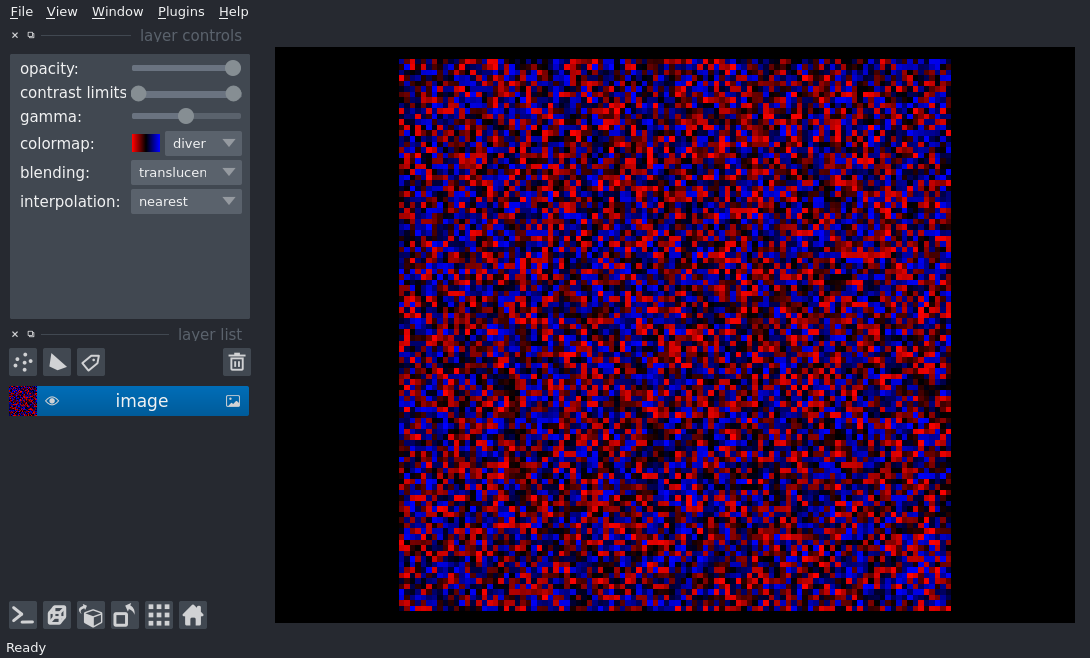

In [11]:
from napari.utils import nbscreenshot

nbscreenshot(viewer)

Note in this example how we passed the colormap keyword argument as a tuple
containing both a name for our new custom colormap and the colormap itself. If
we had only passed the colormap it would have been given a default name.

The named colormap now appears in the dropdown menu alongside a little thumbnail
of the full range of the colormap.

## adjusting contrast limits

Each image layer gets mapped through its colormap according to values called
contrast limits. The contrast limits are a 2-tuple where the second value is
larger than the first. The smaller contrast limit corresponds to the value of
the image data that will get mapped to the color defined by 0 in the colormap.
All values of image data smaller than this value will also get mapped to this
color. The larger contrast limit corresponds to the value of the image data that
will get mapped to the color defined by 1 in the colormap. All values of image
data larger than this value will also get mapped to this color.

For example, you are looking at an image that has values between 0 and 100 with
a standard `gray` colormap, and you set the contrast limits to `(20, 75)`. Then
all the pixels with values less than 20 will get mapped to black, the color
corresponding to 0 in the colormap, and all pixels with values greater than 75
will get mapped to white, the color corresponding to 1 in the colormap. All
other pixel values between 20 and 75 will get linearly mapped onto the range of
colors between black and white.

In napari you can set the contrast limits when creating an `Image` layer or on
an existing layer using the `contrast_limits` keyword argument or property,
respectively.

In [12]:
viewer = napari.view_image(data.moon(), name='moon')
viewer.layers['moon'].contrast_limits=(100, 175)

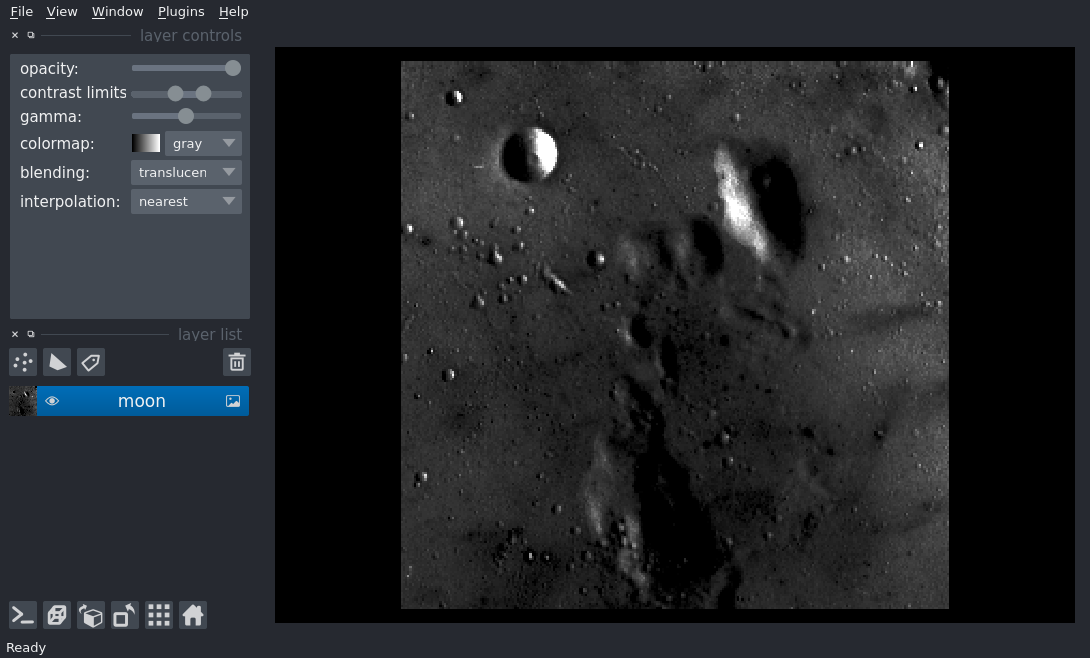

In [13]:
from napari.utils import nbscreenshot

nbscreenshot(viewer)

In [14]:
viewer.close()

Because the contrast limits are defined by two values the corresponding slider
has two handles, one the adjusts the smaller value, one that adjusts the larger
value.

As of right now adjusting the contrast limits has no effect for `rgb` data.

If no contrast limits are passed, then napari will compute them. If your data is
small, then napari will just take the minimum and maximum values across your
entire image. If your data is exceptionally large, this operation can be very
time consuming and so if you have passed an image pyramid then napari will just
use the top level of that pyramid, or it will use the minimum and maximum values
across the top, middle, and bottom slices of your image. In general, if working
with big images it is recommended you explicitly set the contrast limits if you
can.

Currently if you pass contrast limits as a keyword argument to a layer then full
extent of the contrast limits range slider will be set to those values.

## layer visibility

All our layers support a visibility toggle that allows you to set the `visible`
property of each layer. This property is located inside the layer widget in the
layers list and is represented by an eye icon.

## layer opacity

All our layers support an opacity slider and `opacity` property that allow you
to adjust the layer opacity between 0, fully invisible and 1, fully visible.

## blending layers

All our layers support three blending modes `translucent`, `additive`, and
`opaque` that determine how the visuals for this layer get mixed with the
visuals from the other layers.

An `opaque` layer renders all the other layers below it invisible and will fade
to black as you decrease its opacity.

The `translucent` setting will cause the layer to blend with the layers below it
if you decrease its opacity but will fully block those layers if its opacity is
1\. This is a reasonable default, useful for many applications.

The final blending mode `additive` will cause the layer to blend with the layers
below even when it has full opacity. This mode is especially useful for many
cell biology applications where you have multiple different components of a cell
labeled in different colors.

For example:

![image: blending](../assets/tutorials/blending.png)

## layer interpolation

We support a variety of interpolation modes when viewing 2D slices. In the
default mode `nearest` each pixel is represented as a small square of specified
size. As you zoom in you will eventually see each pixel. In other modes
neighbouring pixels are blended together according to different functions, for
example `bicubic`, which can lead to smoother looking images. For most
scientific use-cases `nearest` is recommended because it does not introduce more
artificial blurring. These modes have no effect when viewing 3D slices.

## layer rendering

When viewing 3D slices, we support a variety of rendering modes. The default
mode `mip`, or maximum intensity projection, will combine voxels at different
distances from the camera according to a maximum intensity projection to create
the 2D image that is then displayed on the screen. This mode works well for many
biological images such as these cells growing in culture:

![image: rendering](../assets/tutorials/rendering.png)

When viewing 2D slices the rendering mode has no effect.

## naming layers

All our layers support a `name` property that can be set inside a text box
inside the layer widget in the layers list. The name of each layer is forced
into being unique so that you can use the name to index into `viewer.layers` to
retrieve the layer object.

## scaling layers

All our layers support a `scale` property and keyword argument that will rescale
the layer multiplicatively according to the scale values (one for each
dimension). This property can be particularly useful for viewing anisotropic
volumes where the size of the voxel in the z dimension might be different then
the size in the x and y dimensions.

## translating layers

All our layers support a `translate` property and keyword argument that you can
use to offset a layer relative to the other layers, which could be useful if you
are trying to overlay two layers for image registration purposes.

## layer metadata

All our layers also support a `metadata` property and keyword argument that you
can use to store an arbitrary metadata dictionary on the layer.

## next steps

Hopefully, this tutorial has given you a detailed understanding of the `Image`
layer, including how to create one and control its properties. To learn more
about some of the other layer types that **napari** supports checkout some more
of our tutorials listed below. The [labels layer](./labels) tutorial is a great
one to try next as labels layers are an extension of our image layers used for
labeling regions of images.